In [ ]:
!unzip muzzle.zip

Archive:  muzzle.zip
replace muzzle-augmented/aug368.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '6'
EPOCHS = 1000
BATCH_SIZE = 20

max_images = 1530 # max images per class

In [ ]:
# load labels
csv_path = 'labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [ ]:
# load the images
muzzle_path = 'muzzle'
muzzle_dir = os.listdir(muzzle_path)
x_muzzle = []
y_muzzle = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in muzzle_dir:
    # load the image
    image_path = os.path.join(muzzle_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'muzzle_tension']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images-100):
                x_muzzle.append(img)
                y_muzzle.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images):
                x_muzzle.append(img)
                y_muzzle.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_muzzle.append(img)
                y_muzzle.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [ ]:
# add flipped images from class 2
flipped_path = 'muzzle-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_muzzle.append(img)
    y_muzzle.append(2)
    class_2 += 1

In [ ]:
# add augmented images from class 2
aug_path = 'muzzle-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_muzzle.append(img)
    y_muzzle.append(2)
    class_2 += 1

In [ ]:
print(class_0, class_1, class_2)

1430 1530 1530


In [ ]:
# preprocess
x_muzzle = tf.keras.applications.vgg16.preprocess_input(np.array(x_muzzle))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_muzzle, y_muzzle, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.cast(y_train,dtype=tf.int32)
y_val = tf.cast(y_val,dtype=tf.int32)
y_test = tf.cast(y_test,dtype=tf.int32)

y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [ ]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 4096)              0         
                                                                 
 dense_72 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_36 (Dropout)        (None, 512)               0         
                                                                 
 dense_73 (Dense)            (None, 256)               131328    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 128)             

In [ ]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000
144/144 [==============================] - 4s 14ms/step - loss: 1.2724 - accuracy: 0.3916 - val_loss: 1.0627 - val_accuracy: 0.3964
Epoch 2/1000
144/144 [==============================] - 2s 12ms/step - loss: 1.0434 - accuracy: 0.4114 - val_loss: 1.0182 - val_accuracy: 0.4312
Epoch 3/1000
144/144 [==============================] - 2s 12ms/step - loss: 1.0232 - accuracy: 0.4389 - val_loss: 1.0076 - val_accuracy: 0.4506
Epoch 4/1000
144/144 [==============================] - 2s 12ms/step - loss: 1.0133 - accuracy: 0.4260 - val_loss: 1.0144 - val_accuracy: 0.4339
Epoch 5/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.9993 - accuracy: 0.4553 - val_loss: 1.0123 - val_accuracy: 0.4047
Epoch 6/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.9875 - accuracy: 0.4469 - val_loss: 1.0243 - val_accuracy: 0.4214
Epoch 7/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.9698 - accuracy: 0.4758 - val_loss: 0.9994 - val_ac

In [ ]:
# save the model and training history
path = 'model_' + ITERATION
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'muzzle_history_' + ITERATION +'.csv'
history_df.to_csv(path, index=False)

In [ ]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

29/29 [==============================] - 0s 8ms/step - loss: 1.5940 - accuracy: 0.5122
[1.5939580202102661, 0.5122494697570801]


In [ ]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

29/29 [==============================] - 0s 6ms/step


In [ ]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.51


Classification Report

              precision    recall  f1-score   support

     Score 0       0.48      0.51      0.49       287
     Score 1       0.44      0.53      0.48       316
     Score 2       0.71      0.49      0.58       295

   micro avg       0.51      0.51      0.51       898
   macro avg       0.54      0.51      0.52       898
weighted avg       0.54      0.51      0.52       898
 samples avg       0.51      0.51      0.51       898



Confusion Matrix

[[147 124  16]
 [104 169  43]
 [ 56  95 144]]


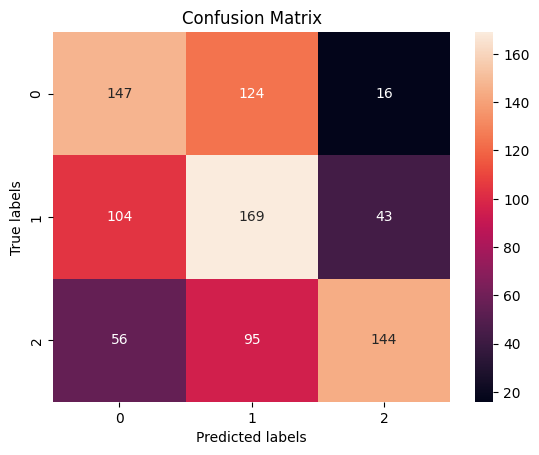

In [ ]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [ ]:
!zip model_5.zip model_5

updating: model_5/ (stored 0%)
